In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from cycler import cycler
import os
#import tikzplotlib

In [2]:
measurements = dict()
REDUCTIONS = 'all domination no-necessary no-domination simple none'.split(' ')
MODES = 'normal all-zi'.split()
for mode in MODES:
    measurements[mode] = {k: pd.read_csv(f'{mode}/red_{k}.csv', comment='#').sort_values(['n', 'name']) for k in REDUCTIONS}
    timeout = 5.4e9
    for k, v in measurements[mode].items():
        #v.drop(v[v['run'] == 0].index, inplace = True)
        #v.drop(v[v['n'] < 20].index, inplace = True)
        v['t_total'] /= 1000
        v['t_reductions'] /= 1000
        v['t_solver'] /= 1000
    baseline = measurements[mode]['none'].groupby('name').median(numeric_only=True)
    optimal = measurements[mode]['all'].groupby('name')['pmus'].min()
    for k, v in measurements[mode].items():
        v['non-zi'] = v['n'] - v['zi']
        v['t_baseline'] = baseline['t_total'][v['name']].to_numpy()
        v['speedup'] = baseline['t_total'][v['name']].to_numpy() / v['t_total'].to_numpy()
        v['percent_blank'] = v['blank_reduced'] / v['n']
        v['percent_kernel_blank'] = v['blank_reduced'] / v['n_reduced']
        v['percent_remaining'] = v['n_reduced'] / v['n']
        pmus = optimal[v['name']].to_numpy()
        v['reduction_absolute_gap'] = pmus - v['pmu_reduced']
        v['reduction_gap'] = v['reduction_absolute_gap'] / pmus

In [3]:
MODE = 'normal'

In [4]:
FIGSIZE=np.array((15, 10))
def default_args(argDict, **kwargs):
    for k, v in kwargs.items():
        if k not in argDict: argDict[k] = v
    return argDict

def setupAxes(ax):
    cmap = mpl.colormaps['tab10']
    colorcycle = cycler(color=[cmap.colors[i] for i in range(10)])
    markercycle = cycler(marker=['+', 'x', '*', '1', '2', '3', '4', '.', 'p', 'o'])
    #markercycle = cycler(marker=['P', 'X', (5, 1), (3, 1), (3, 1, 90), (3, 1, 180), (3, 1, 270), '.', 'p', 'o'])
    ax.set_prop_cycle(colorcycle + markercycle)

def drawScatterPlot(ax, data, key='t_total', scaley=1, scalex=1, x='n', **kwargs):
    grouped = data.groupby('name', sort=False)
    data = pd.DataFrame({'n': grouped[x].median() * scalex, 'min': grouped[key].min()*scaley, 'max': grouped[key].max()*scaley, 'median': grouped[key].median()*scaley})
    ax.plot(data['n'], data['median'], **kwargs)
    
COLUMN_NAMES=dict(
    pmus='#PMUs', t_total='total time', t_reductions='reduction time (ms)', t_solver='MILP time (ms)', 
    n='#buses', m='#lines', zi='#zero-injection', n_reduced='#buses after reductions', 
    m_reduced='#lines after reductions', zi_reduced='#zero-injection after reductions',
    pmu_reduced='#PMUs after reductions', blank_reduced='#blank after reductions', 
    percent_blank='% blank', percent_remaining='% remaining nodes', 
    reduction_absolute_gap='#PMUs missed by reduction', reduction_gap='reduction optimality gap (%)')

def drawPlot(x, y, mode = MODE, ax = None,
             xscale='log', yscale='log', 
             ignore='', rename=dict(), figsize=FIGSIZE, **kwargs):
    if not ax:
        ax = plt.figure(figsize=figsize).subplots()
        setupAxes(ax)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel(COLUMN_NAMES.get(x, x))
    ax.set_ylabel(COLUMN_NAMES.get(y, y))
    kwargs = default_args(kwargs, alpha=0.7, linestyle='')
    for k, v in measurements[mode].items():
        if k in ignore: 
            plt.plot([], [])
            continue
        k = rename.get(k, k)
        drawScatterPlot(ax, v, x=x, key=y, label=k, **kwargs)
    return ax

def boxPlot(ax, dta, yscale='log'):
    for i, mode in enumerate(MODES):
        data = [v[dta] for v in measurements[mode].values()]
        base_positions = np.arange(1, len(data) + 1, dtype=np.float64)
        positions = base_positions + 0.2 * ( 2*i - 1)
        line, = ax.plot([],[], label=mode)
        ax.boxplot(data, positions=positions, widths=0.3, medianprops={'color': line.get_color(), 'lw': line.get_lw()})
        ax.set_xticks(base_positions)
        ax.set_yscale(yscale)
        ax.set_xticklabels(measurements[MODE].keys())
        ax.set_ylabel(COLUMN_NAMES.get(dta, dta))
        plt.setp(ax.get_xticklabels(), rotation=10)

def drawTimeouts(ax, times=[(1, '1ms'), (1e3, '1s'), (6e4, '1min'), (3.6e6, '1h'), (timeout/1000, 'Timeout (5400s)')], pos = 12):
    xmin, xmax = ax.get_xlim()
    for y, l in times:
        ax.plot([xmin, xmax], [y, y], color='gray', marker='')
        ax.text(np.log((xmin + xmax)) * pos, y, l)
    ax.set_xlim((xmin, xmax))


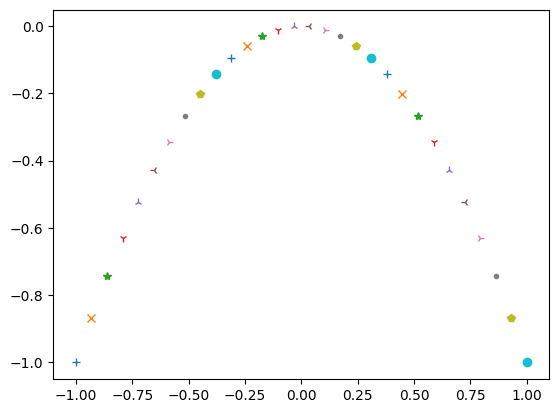

In [5]:
ax = plt.figure().subplots(1, 1)
setupAxes(ax)
for x in np.linspace(-1, 1, 30):
    ax.plot([x], [-x*x])

## Running Time and Speedup
In most instances the reduction rules could achieve a significant speedup of several orders of magnitude.
We saw the best results when using all reduction rules.
There are exceptions where excluding the “necessary nodes” rule was even faster.
In these instances both sets of reduction rules could completely solve the instance and thus the time for the single rules contributed significantly to the total running time.

Note that there are instances with negative speedup.
All of these are very small instances which remained mostly or fully unchanged by the reduction rules.
In these cases the MILP does not run faster and the the time for the reductions is added to its running time resulting in a higher total running time thatn without reduction rules.
Because those instances are very small and can be solver very quickly anyway, this does not have a huge impact overall.

Assuming that all nodes are zero-injection results in a considerably larger speedup.
With all reduction rules the speedup is one order of magnitude larger when all vertices are zero-injection.

In [6]:
last_data = None
for mode in MODES:
    for red in REDUCTIONS:
        data = measurements[mode][red]
        data = data[data['pmus'] == 0]
        if not data.empty:
            last_data = data
            print(data[data['pmus'] == 0])
last_data

In [7]:
{(red, mode): any(map(lambda x: x == 0, measurements[mode][red]['pmus'])) for mode in MODES for red in REDUCTIONS}

{('all', 'normal'): False,
 ('domination', 'normal'): False,
 ('no-necessary', 'normal'): False,
 ('no-domination', 'normal'): False,
 ('simple', 'normal'): False,
 ('none', 'normal'): False,
 ('all', 'all-zi'): False,
 ('domination', 'all-zi'): False,
 ('no-necessary', 'all-zi'): False,
 ('no-domination', 'all-zi'): False,
 ('simple', 'all-zi'): False,
 ('none', 'all-zi'): False}

normal all [ 0.89762641 -4.39921243] x^0.897626 * 0.012287
normal none [ 0.97578852 -3.11290428] x^0.975789 * 0.044472
all-zi all [ 1.14206707 -6.27501254] x^1.142067 * 0.001883
all-zi none [ 1.19912211 -3.70530145] x^1.199122 * 0.024593


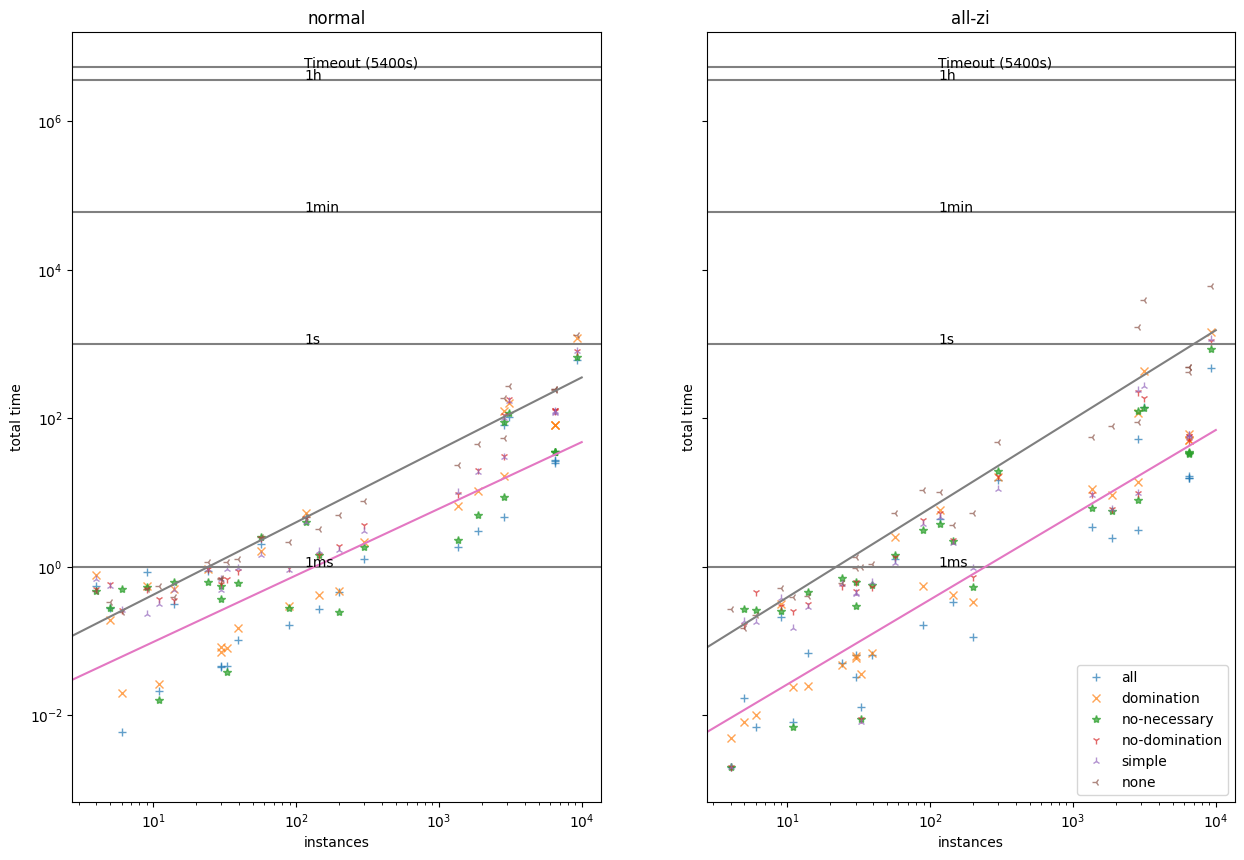

In [8]:
axs = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True); col='t_total'
ignore = 'none'
for mode, ax in zip(MODES, axs):
    setupAxes(ax)
    drawPlot(ax=ax,y=col, x='n', xscale='log', mode=mode)
    ax.set_title(mode)
    drawTimeouts(ax)
    times = pd.DataFrame(dict(n= measurements[mode][REDUCTIONS[0]].groupby('name').median(numeric_only=True)['n'], **{red: measurements[mode][red].groupby('name').median(numeric_only=True)['t_total'] for red in REDUCTIONS}))
    times.sort_values('n').to_csv(f'figures/running_times_{mode}.csv')
for ax in axs: ax.set_xlabel('instances')
axs[1].legend(); axs[0].set_ylabel(COLUMN_NAMES.get(col, col));
for mode, ax in zip(MODES, axs):
    for red in [REDUCTIONS[0], REDUCTIONS[-1]]:
        coefs = np.polyfit(np.log(measurements[mode][red]['n']), np.log(measurements[mode][red]['t_total']), 1)
        print(mode, red, coefs, f'x^{coefs[0]:f} * {np.exp(coefs[1]):f}')
        xs = np.linspace(2, 10000)
        ys = xs**coefs[0] * np.exp(coefs[1])
        ax.plot(xs, ys, marker='')
    
#tikzplotlib.save('figures/running_times.tikz.tex'); plt.show();

In [9]:
def num_fmt(x):
    return f'{x:,.2f}'

def si_prefix(x, maximum=float('inf')):
    if x > maximum:
        return f'{{>{num_fmt(maximum)}}}'
    if x < 0.001:
        return f'{{{num_fmt(x * 1000000)}$\mu$}}'
    if x < 1:
        return f'{{{num_fmt(x*1000)}m}}'
    return f'{x:.2f}'

In [17]:
outputs = []
os.makedirs(f'tables/', exist_ok=True)
for mode in MODES:
    baseline_timeouts = (measurements[mode]['none'].set_index(['name', 'run'])['result'] == 'Optimal') * 1.0
    baseline_timeouts = baseline_timeouts.groupby('name').median()
    data = measurements[mode]['all'].copy()
    data = data.groupby('name').median(numeric_only=True).sort_values(['n', 'name'])
    data['base_solved'] = baseline_timeouts
    data.index = pd.Index([s[s.find('/')+1:s.rfind('.')] for s in data.index], name='name')
    time_cols = 't_total t_reductions t_solver t_baseline'.split()
    data[time_cols] /= 1000
    data[time_cols] = data[time_cols].applymap(lambda x: si_prefix(x, 5400))
    data = data[['n', 'non-zi', 'pmus', 'base_solved', 't_total', 't_reductions', 't_solver', 't_baseline', 'speedup',
       'm', 'n_reduced', 'm_reduced', 'zi_reduced', 'pmu_reduced',
       'blank_reduced', 'percent_blank',
       'percent_kernel_blank', 'percent_remaining', 'reduction_absolute_gap',
       'reduction_gap']]
    data.to_csv(f'tables/times_{mode}.csv')
    outputs.append(data)
data = pd.concat([outputs[0], outputs[1]]).sort_values(['n', 'name'])
data.to_csv('tables/all_times.csv')
outputs[0]
data

n  non-zi    pmus  base_solved        t_total   
name                                                                   
case4gs              4.0     4.0     2.0          1.0  {543.00$\mu$}  \
case4gs              4.0     0.0     1.0          1.0    {2.00$\mu$}   
case5                5.0     5.0     2.0          1.0  {280.00$\mu$}   
case5                5.0     0.0     1.0          1.0   {17.00$\mu$}   
case6ww              6.0     5.0     1.0          1.0    {6.00$\mu$}   
case6ww              6.0     0.0     1.0          1.0    {7.00$\mu$}   
case9                9.0     5.0     2.0          1.0  {848.00$\mu$}   
case9                9.0     0.0     2.0          1.0  {211.00$\mu$}   
case11_iwamoto      11.0     5.0     2.0          1.0   {21.00$\mu$}   
case11_iwamoto      11.0     0.0     2.0          1.0    {8.00$\mu$}   
case14              14.0    12.0     3.0          1.0  {312.00$\mu$}   
case14              14.0     0.0     2.0          1.0   {68.00$\mu$}   
case24_ieee_rts     24.0    20.0     6.0          1.0  {876.00$\mu$}   
case24_ieee_rts     24.0     0.0     3.0          1.0   {50.00$\mu$}   
case30              30.0    23.0     6.0          1.0   {46.00$\mu$}   
case30              30.0     0.0     3.0          1.0   {33.00$\mu$}   
case_ieee30         30.0    23.0     6.0          1.0   {45.00$\mu$}   
case_ieee30         30.0     0.0     3.0          1.0   {64.00$\mu$}   
case33bw            33.0    32.0    11.0          1.0   {46.00$\mu$}   
case33bw            33.0     0.0     2.0          1.0   {13.00$\mu$}   
case39              39.0    29.0     9.0          1.0  {103.00$\mu$}   
case39              39.0     0.0     5.0          1.0   {65.00$\mu$}   
case57              57.0    42.0    12.0          1.0        {2.06m}   
case57              57.0     0.0     3.0          1.0        {1.28m}   
case89pegase        89.0    46.0    13.0          1.0  {166.00$\mu$}   
case89pegase        89.0     0.0     5.0          1.0  {166.00$\mu$}   
case118            118.0   107.0    29.0          1.0        {4.67m}   
case118            118.0     0.0     8.0          1.0        {4.36m}   
case145            145.0    74.0    18.0          1.0  {269.00$\mu$}   
case145            145.0     0.0    13.0          1.0  {336.00$\mu$}   
case_illinois200   200.0   156.0    39.0          1.0  {463.00$\mu$}   
case_illinois200   200.0     0.0    20.0          1.0  {114.00$\mu$}   
case300            300.0   234.0    72.0          1.0        {1.26m}   
case300            300.0     0.0    30.0          1.0       {14.56m}   
case1354pegase    1354.0   932.0   311.0          1.0        {1.87m}   
case1354pegase    1354.0     0.0   176.0          1.0        {3.49m}   
case1888rte       1888.0  1207.0   375.0          1.0        {3.03m}   
case1888rte       1888.0     0.0   235.0          1.0        {2.44m}   
case2848rte       2848.0  1825.0   585.0          1.0        {4.72m}   
case2848rte       2848.0     0.0   352.0          1.0        {3.17m}   
case2869pegase    2869.0  2000.0   612.0          1.0       {80.40m}   
case2869pegase    2869.0     0.0   305.0          1.0       {53.16m}   
case3120sp        3120.0  2322.0   768.0          1.0      {103.38m}   
case3120sp        3120.0     0.0   231.0          1.0      {143.11m}   
case6470rte       6470.0  4118.0  1303.0          1.0       {24.71m}   
case6470rte       6470.0     0.0   745.0          1.0       {16.71m}   
case6495rte       6495.0  4151.0  1314.0          1.0       {26.59m}   
case6495rte       6495.0     0.0   757.0          1.0       {15.61m}   
case6515rte       6515.0  4171.0  1315.0          1.0       {27.36m}   
case6515rte       6515.0     0.0   757.0          1.0       {15.80m}   
case9241pegase    9241.0  6339.0  2010.0          1.0      {619.73m}   
case9241pegase    9241.0     0.0   811.0          1.0      {480.94m}   

                   t_reductions       t_solver     t_baseline     speedup   
name                                                     

In [18]:
for i, mode in enumerate(MODES):
    data = [v['speedup'] for v in measurements[mode].values()]
    index = ['mean', 'med', 'q1', 'q3', 'cihi', 'cilo', 'whishi', 'whislo']
    values = [[b[i] for i in index] + list(b['fliers']) for b in boxplot_stats(data)]
    max_len = max(map(len, values))
    index = index + [i for i in range(max_len-len(index))]
    values = [index] + values
    boxdata = pd.concat(map(pd.Series, values), axis=1, ignore_index=True).set_index(0)
    boxdata.columns=measurements[mode].keys()
    boxdata.to_csv(f'figures/speedup_boxes_{mode}.csv', na_rep='nan')
#boxdata

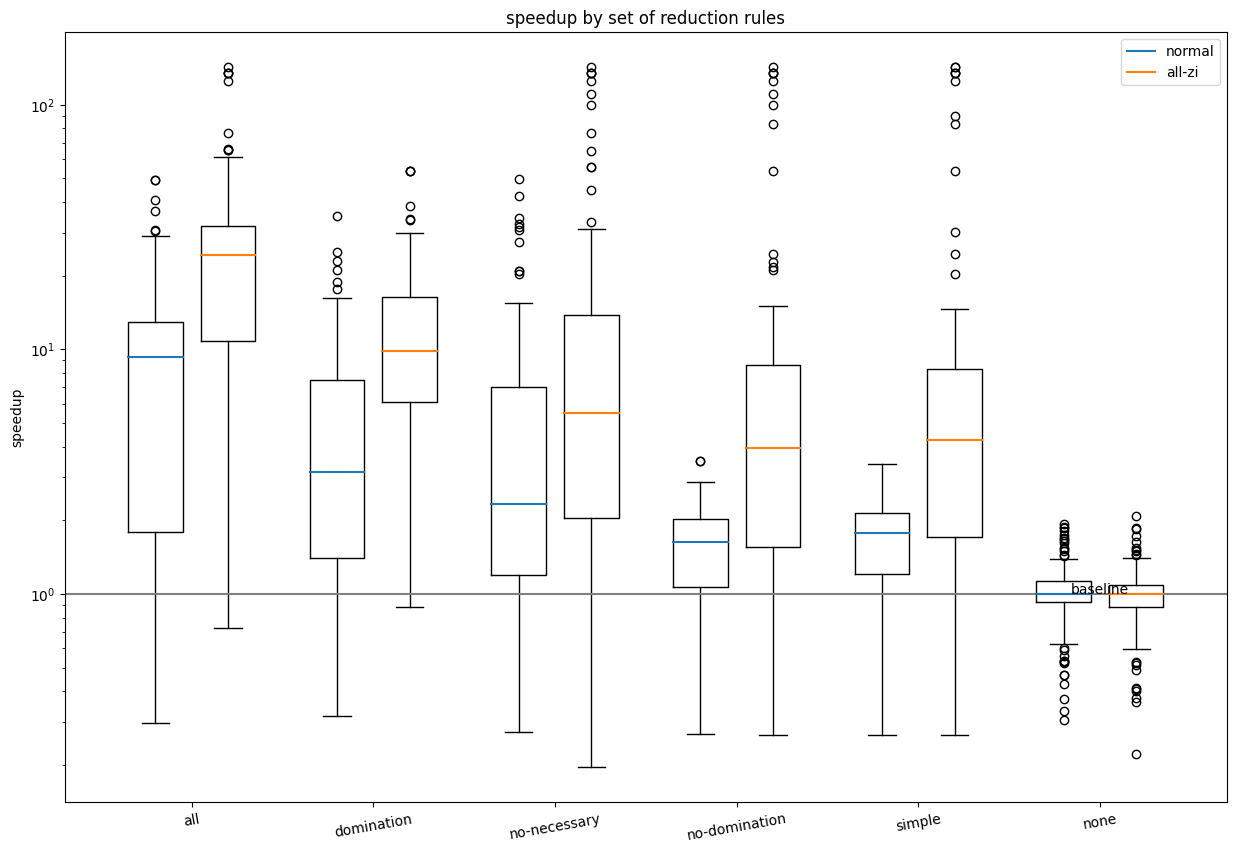

In [19]:
ax = plt.figure(figsize=FIGSIZE).subplots()#1, 2, sharey=True)
#axs[1].tick_params('y', )
boxPlot(ax, 'speedup')
ax.set_title('speedup by set of reduction rules')
ax.legend()
drawTimeouts(ax, times=[(1, 'baseline')], pos=3)
#tikzplotlib.save('figures/speedup_boxes.tikz.tex'); plt.show();

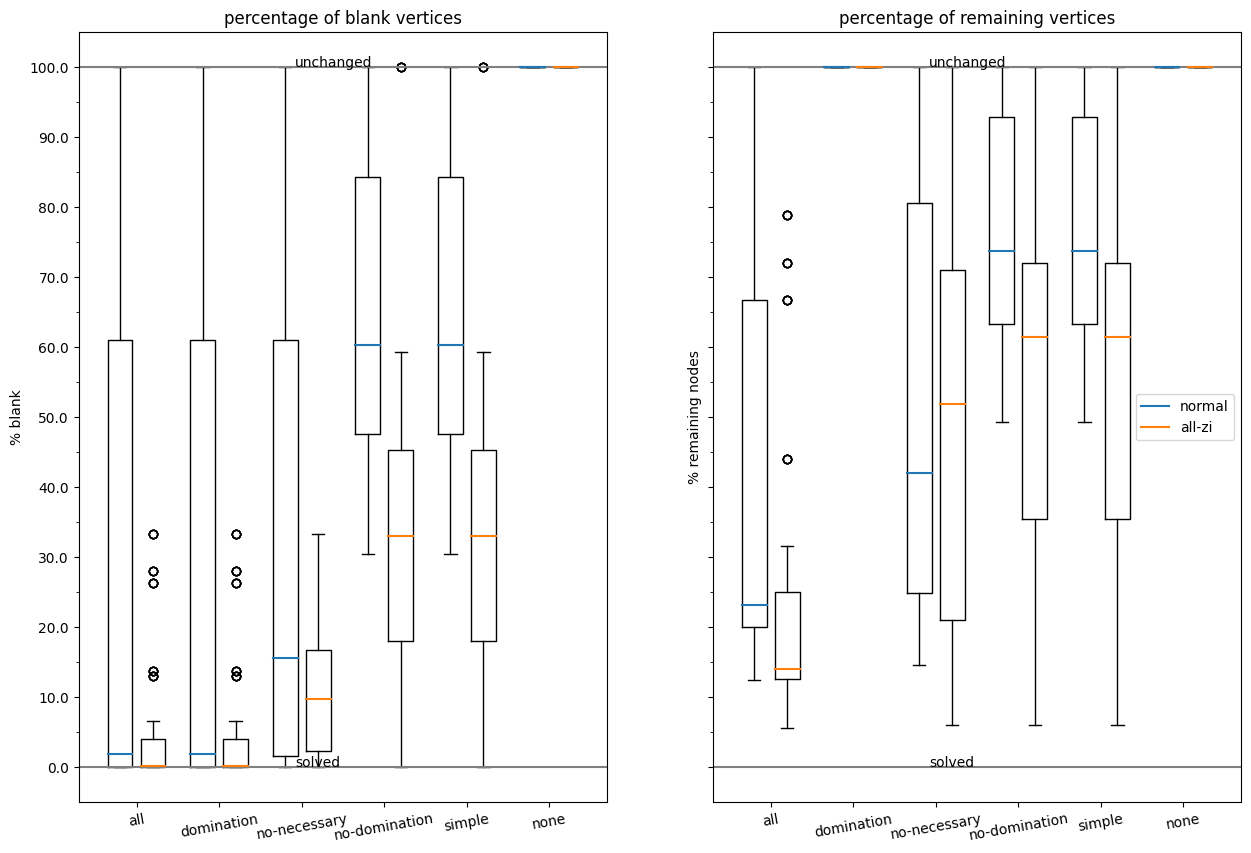

In [20]:
ax = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True)
boxPlot(ax[0], 'percent_blank', yscale='log')
boxPlot(ax[1], 'percent_remaining', yscale='linear')
ax[0].set_title('percentage of blank vertices')
ax[1].set_title('percentage of remaining vertices')
ax[1].legend()
ax[0].set_yticks(np.linspace(0, 1, 11)); ax[0].set_yticks(np.linspace(0, 1, 21), minor=True); ax[0].set_yticklabels(np.round(np.linspace(0, 100, 11), 2))
for a in ax: drawTimeouts(a, times=[(0, 'solved'), (1, 'unchanged')], pos=1.5)
#tikzplotlib.save('figures/blank_remaining_boxes.tikz.tex'); plt.show();

/tmp/ipykernel_1298163/761896000.py:53: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.set_xticks(base_positions)
/tmp/ipykernel_1298163/761896000.py:53: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.set_xticks(base_positions)
/tmp/ipykernel_1298163/761896000.py:53: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.set_xticks(base_positions)
/tmp/ipykernel_1298163/761896000.py:64: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  ax.set_xlim((xmin, xmax))


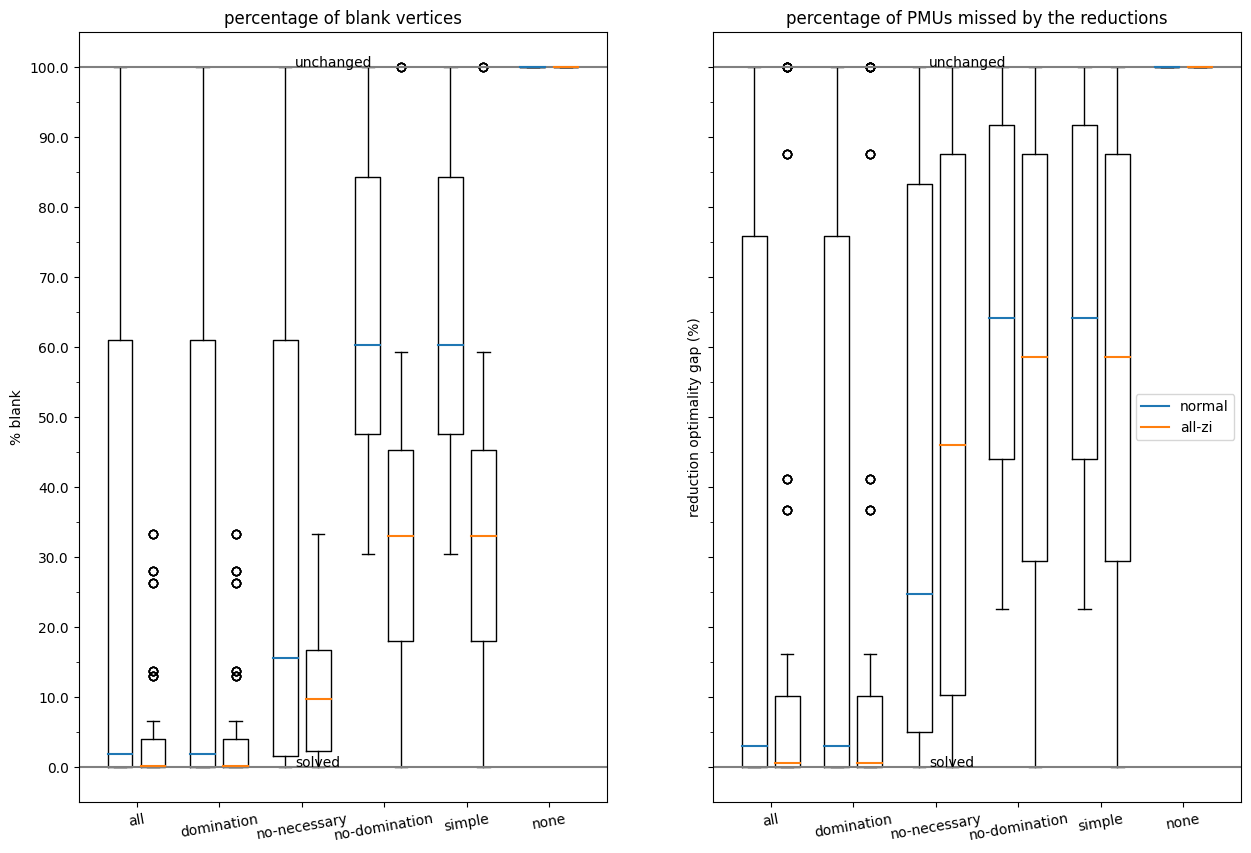

In [21]:
ax = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True)
boxPlot(ax[0], 'percent_blank', yscale='symlog')
boxPlot(ax[1], 'reduction_gap', yscale='symlog')
ax[0].set_title('percentage of blank vertices')
ax[1].set_title('percentage of PMUs missed by the reductions')
ax[1].legend()
ax[0].set_yticks(np.linspace(0, 1, 11)); ax[0].set_yticks(np.linspace(0, 1, 21), minor=True); ax[0].set_yticklabels(np.round(np.linspace(0, 100, 11), 2))
for a in ax: drawTimeouts(a, times=[(0, 'solved'), (1, 'unchanged')], pos=1.5)
#tikzplotlib.save('figures/blank_gap_boxes.tikz.tex'); plt.show();

In [22]:
for mode in MODES: 
    for red in REDUCTIONS:
        if red == 'none': continue
        m = measurements[mode][red][::4]
        print(red); print(m[m['n'] == m['blank_reduced']].name)

all
0    inputs/case4gs.graphml
4    inputs/case4gs.graphml
Name: name, dtype: object
domination
0    inputs/case4gs.graphml
4    inputs/case4gs.graphml
Name: name, dtype: object
no-necessary
0    inputs/case4gs.graphml
4    inputs/case4gs.graphml
Name: name, dtype: object
no-domination
0     inputs/case4gs.graphml
4     inputs/case4gs.graphml
8       inputs/case5.graphml
12    inputs/case6ww.graphml
Name: name, dtype: object
simple
0     inputs/case4gs.graphml
4     inputs/case4gs.graphml
8       inputs/case5.graphml
12    inputs/case6ww.graphml
Name: name, dtype: object
all
Series([], Name: name, dtype: object)
domination
Series([], Name: name, dtype: object)
no-necessary
Series([], Name: name, dtype: object)
no-domination
12    inputs/case6ww.graphml
Name: name, dtype: object
simple
12    inputs/case6ww.graphml
Name: name, dtype: object


In [23]:
print('relative reduction gap'); pd.DataFrame({mode: {red: np.round(measurements[mode][red]['reduction_gap'].median() * 100, 1) for red in REDUCTIONS} for mode in MODES}).T

relative reduction gap


all  domination  no-necessary  no-domination  simple   none
normal  3.1         3.1          24.8           64.1    64.1  100.0
all-zi  0.6         0.6          45.9           58.5    58.5  100.0

In [24]:
print('median blank percentage'); pd.DataFrame({mode: {red: np.round(measurements[mode][red]['percent_blank'].median() * 100, 1) for red in REDUCTIONS} for mode in MODES}).T

median blank percentage


all  domination  no-necessary  no-domination  simple   none
normal  1.9         1.9          15.5           60.3    60.3  100.0
all-zi  0.1         0.1           9.7           33.0    33.0  100.0

The higher speed-up in all-zero-injection instances can be explained when looking at the remaining kernels.
The left plot shows the percentage of vertices that remain blank compared to the original number of vertices.
We see that applying all reductions leads to a significant decrease in blank vertices with around 3.0\% remaining in the median instance with some zero-injection vertices.
If the initial vertices are all zero-injection, this goes does down to 0.1\%.

Note that there are instance which are not changed at all by the reductions.
All of these are small instances consisting of four to six non-zero-injection vertices.
The reduction rules presented here are mostly targeted at non-zero-injection vertices and do not affect those instances.
The “domination” set is a special case: It does not remove vertices and thus, the kernel has the same number of vertices as the input.
When considering only the number of remaining blank vertices, it has the same result as all reduction rules.
This is interesting because the speedup of this set when compared to all rules is considerable lower.
There is a simple explanation for this divergence: the MILP model cannot discard active and inactive vertices and thus results in a larger number of variables. // TODO: quantify //


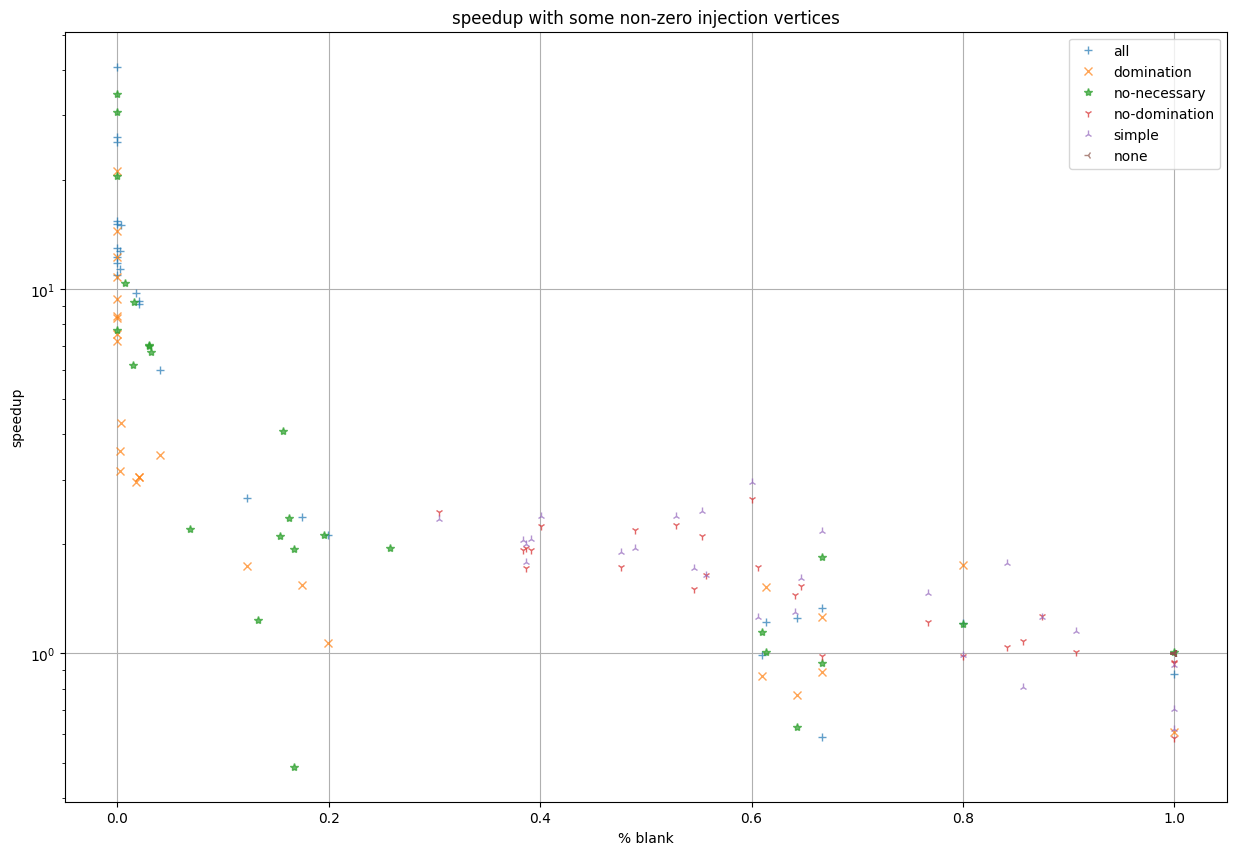

In [25]:
ax = drawPlot(y='speedup', x='percent_blank', xscale='linear', mode='normal')
ax.legend(); ax.grid()
ax.set_title('speedup with some non-zero injection vertices')
plt.show();

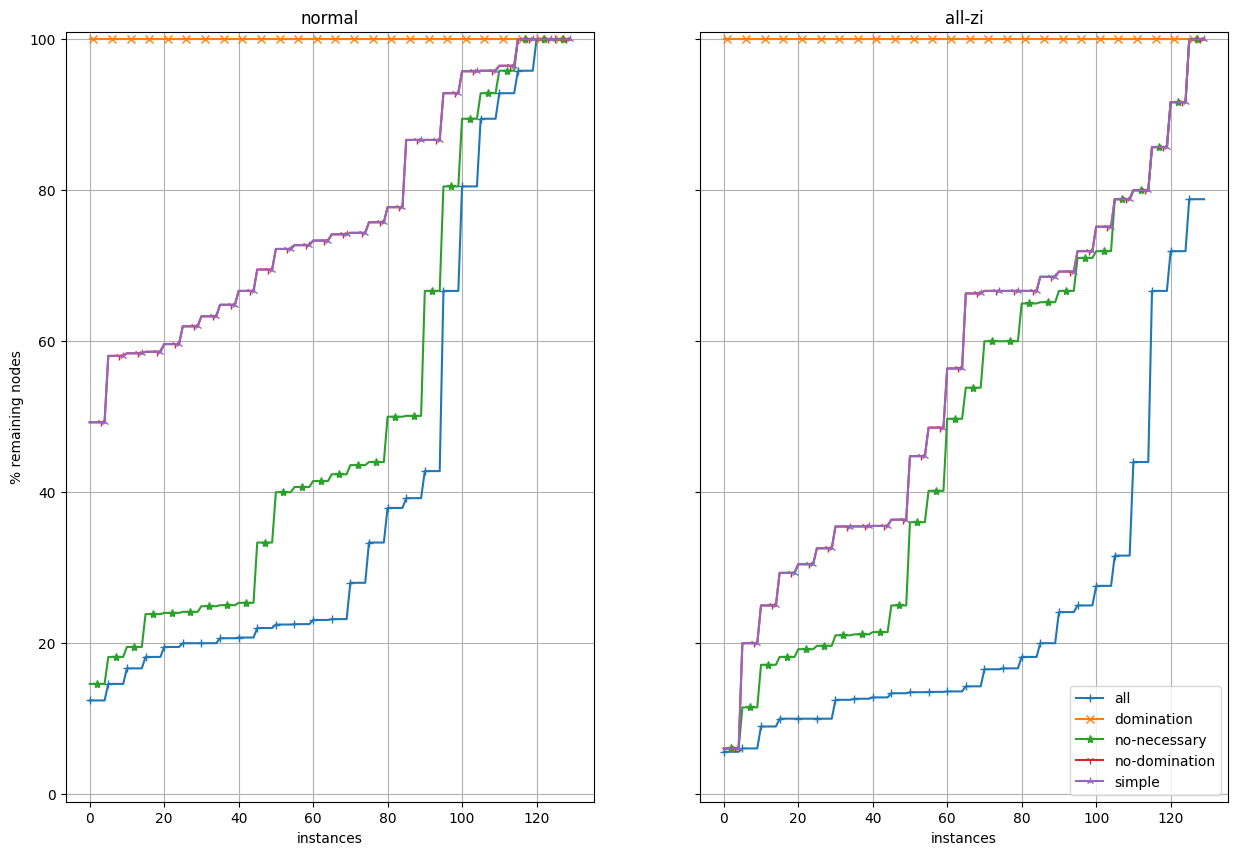

In [26]:
axs = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True); col = 'percent_remaining'
ignore = 'none'
for mode, ax in zip(MODES, axs):
    ax.set_ylim(-1, 101)
    setupAxes(ax); ax.set_title(mode); ax.grid() # axis setup
    for j, red in enumerate(REDUCTIONS):
        if red not in ignore: ax.plot(measurements[mode][red][col].sort_values().to_numpy() * 100, label=red, markevery=(j,5))
        else: plt.plot([],[])
for ax in axs: ax.set_xlabel('instances')
axs[1].legend(); axs[0].set_ylabel(COLUMN_NAMES.get(col, col)); 
for mode in MODES:
    pd.DataFrame({red: measurements[mode][red][col].sort_values(ignore_index=True) * 100 for red in REDUCTIONS}).to_csv(f'figures/percent_remaining_{mode}.csv')
#tikzplotlib.save('figures/percent_remaining.tikz.tex'); plt.show();

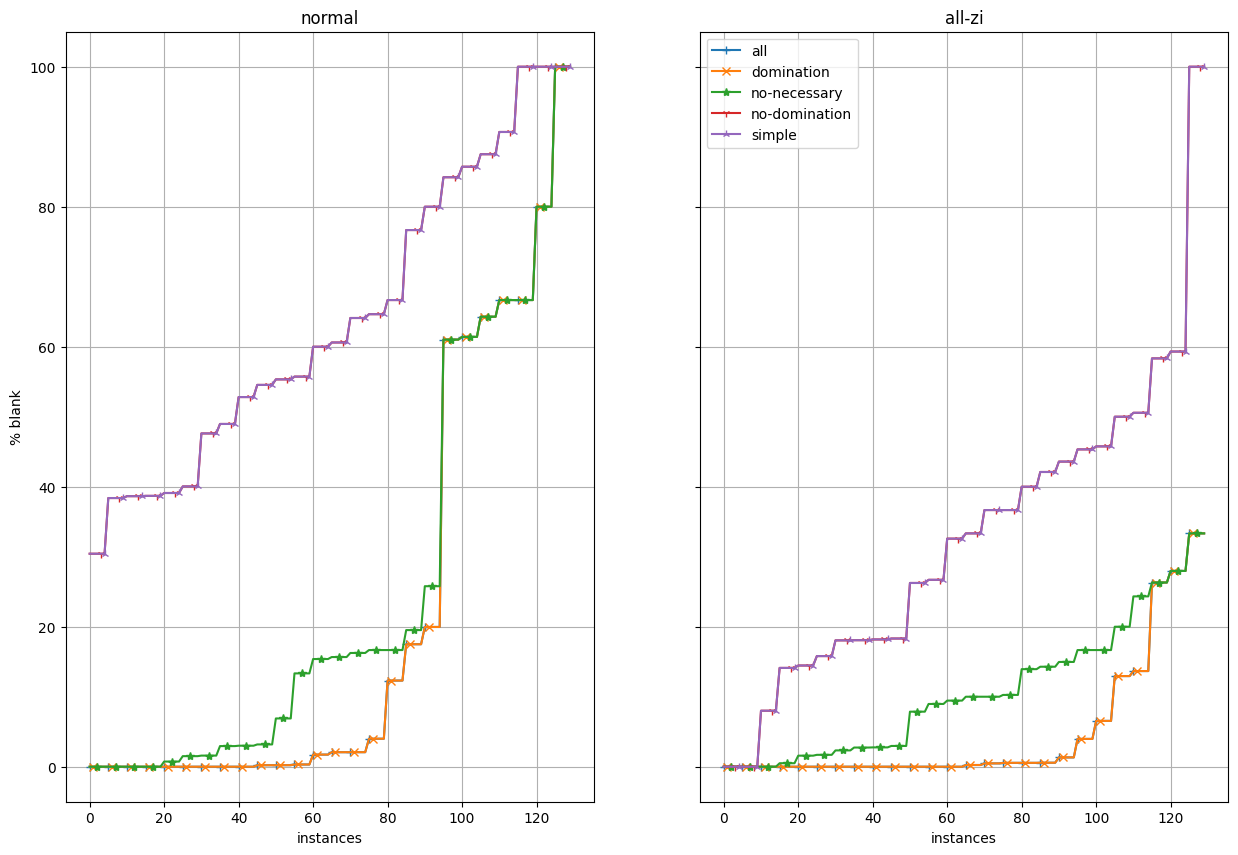

In [27]:
axs = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True); col = 'percent_blank'
for mode, ax in zip(MODES, axs):
    setupAxes(ax); ax.set_title(mode); ax.grid() # axis setup
    for j, red in enumerate(red for red in REDUCTIONS if red != 'none'):
        ax.plot(measurements[mode][red][col].sort_values().to_numpy() * 100, label=red, markevery=(j,5))
for ax in axs: ax.set_xlabel('instances')
axs[1].legend(); axs[0].set_ylabel(COLUMN_NAMES.get(col, col)); 
for mode in MODES:
    pd.DataFrame({red: measurements[mode][red][col].sort_values(ignore_index=True) * 100 for red in REDUCTIONS}).to_csv(f'figures/percent_blank_{mode}.csv')
#tikzplotlib.save('figures/percent_blank.tikz.tex'); plt.show();

In [28]:
dta = pd.DataFrame({mode: {red: len(measurements[mode][red][measurements[mode][red]['blank_reduced'] == 0]) for red in REDUCTIONS} for mode in MODES}).T
pd.DataFrame({'#instances': {mode: len(measurements[mode]['all']) for mode in MODES}}).join(dta) // 5

#instances  all  domination  no-necessary  no-domination  simple  none
all-zi          26   13          13             3              2       2     0
normal          26    9           9             4              0       0     0

Wih the all-zero-injection variants of the inputs the reduction rules could already solve half of the instances.
This number reduced to 30\% when considering only some vertices zero-injection.
Leaving out either of the domination based rules significantly decreases this number.
With only zero-injection vertices, the reductions without the observation-neighborhood rule were only able to solve one instance with only zero-injection vertices and none that contained non-zero-injection vertices.
Leaving out the necessary-nodes rule resulted in 3 and 4 solved instances respectively.
It is clear from this data that the two domination rules complement each other.

The line plots //TODO: figure out name of this type of plot // also show that using the necessary-nodes rule with the local rules does not have any benefit iver the local rules alone.
The rule does however have a great effect when used in conjunction with the observation-neighborhod rule.
Note that the green line marked with stars is the kernel found by the all rules except the necessary rule and its kernel is much larger than the one found with both domination rules.
There are, however, some instances in which the kernel found without the necessary rule has the same number of blank nodes as with that rule.
It is still clear that using this rule greatly improves the kernel quality despite having little to no effect on its own.

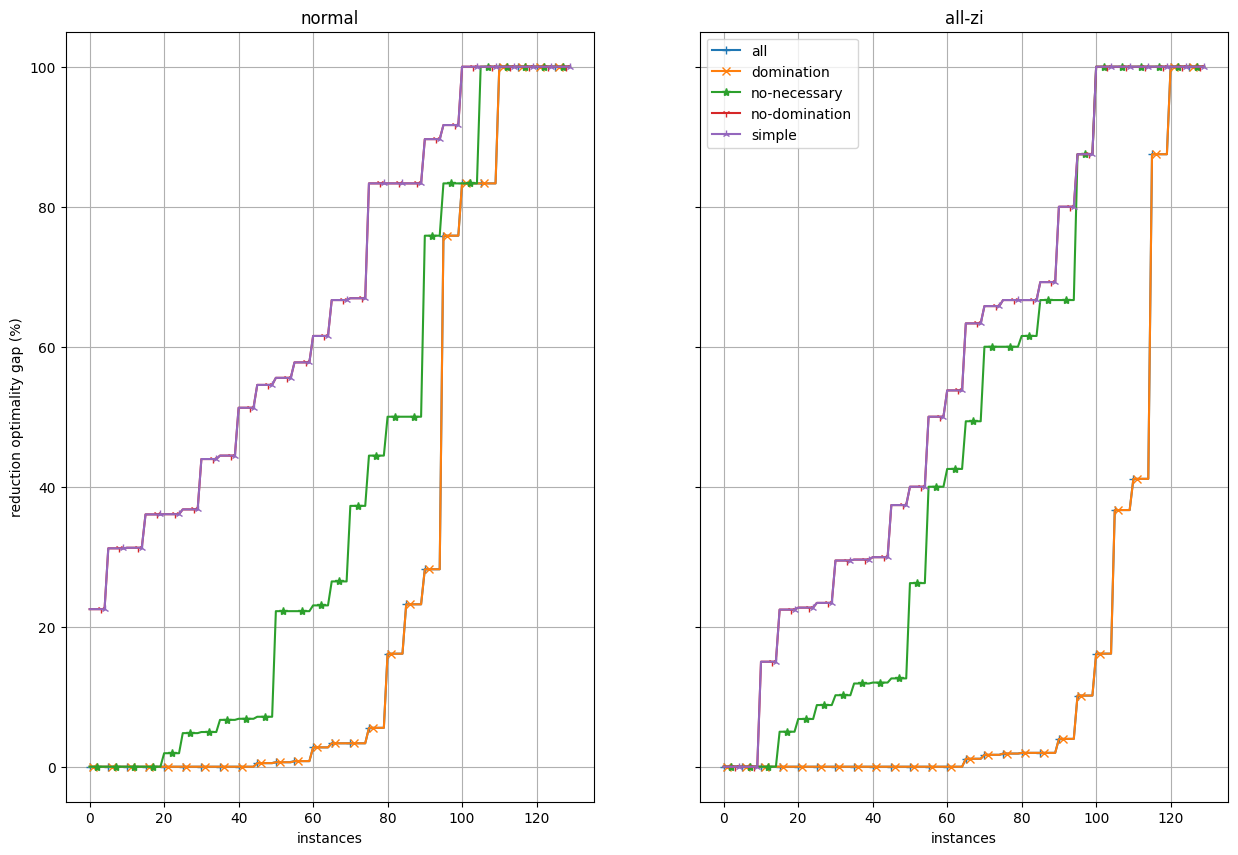

In [29]:
axs = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True); col = 'reduction_gap'
#axin = axs[0].inset_axes([0.12, 0.69, 0.4, 0.3])
#axin.set_xlim(-2, 42); axin.set_ylim(-.4, 8.4); axin.grid(); axs[0].indicate_inset_zoom(axin, edgecolor='black');setupAxes(axin)
for mode, ax in zip(MODES, axs):
    setupAxes(ax); ax.set_title(mode); ax.grid() # axis setup
    for j, red in enumerate(red for red in REDUCTIONS if red != 'none'):
        ax.plot(measurements[mode][red][col].sort_values().to_numpy() * 100, label=red, markevery=(j,5))
        if mode == MODES[0]:
            pass#axin.plot(measurements[mode][red][col].sort_values().to_numpy() * 100, label=red, markevery=(j,5))

for ax in axs: ax.set_xlabel('instances')
axs[1].legend(); axs[0].set_ylabel(COLUMN_NAMES.get(col, col));
for mode in MODES:
    pd.DataFrame({red: measurements[mode][red][col].sort_values(ignore_index=True) * 100 for red in REDUCTIONS}).to_csv(f'figures/reduction_gap_{mode}.csv')
#tikzplotlib.save('figures/reduction_gap.tikz.tex'); plt.show();

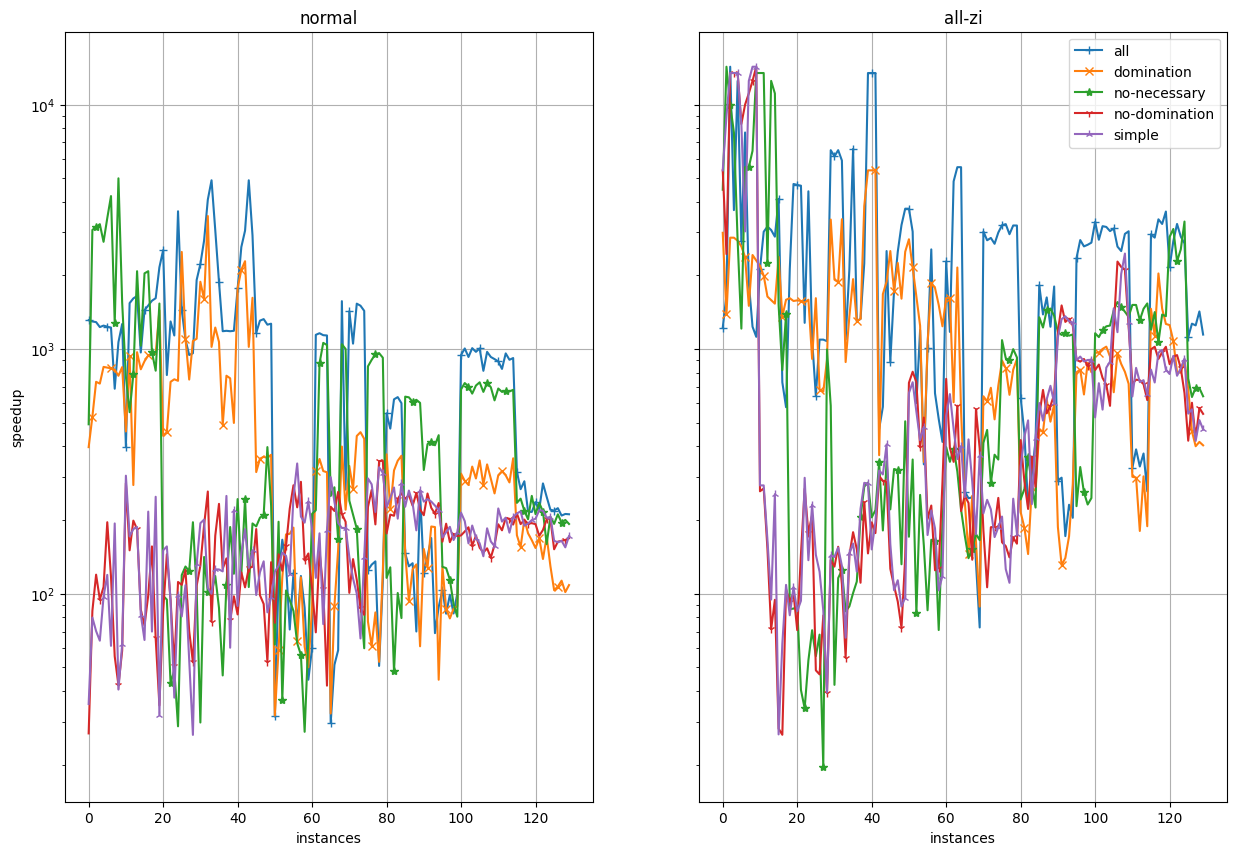

In [30]:
axs = plt.figure(figsize=FIGSIZE).subplots(1, 2, sharey=True); col = 'speedup'
#axin = axs[0].inset_axes([0.12, 0.69, 0.4, 0.3])
#axin.set_xlim(-2, 42); axin.set_ylim(-.4, 8.4); axin.grid(); axs[0].indicate_inset_zoom(axin, edgecolor='black');setupAxes(axin)
for mode, ax in zip(MODES, axs):
    setupAxes(ax); ax.set_title(mode); ax.grid() # axis setup
    for j, red in enumerate(red for red in REDUCTIONS if red != 'none'):
        ax.plot(measurements[mode][red].sort_values('blank_reduced')[col].to_numpy() * 100, label=red, markevery=(j,5))
        if mode == MODES[0]:
            pass#axin.plot(measurements[mode][red][col].sort_values().to_numpy() * 100, label=red, markevery=(j,5))

for ax in axs: ax.set_xlabel('instances'); ax.set_yscale('log')
axs[1].legend(); axs[0].set_ylabel(COLUMN_NAMES.get(col, col));
for mode in MODES:
    pass
    #pd.DataFrame({red: measurements[mode][red][col].sort_values(ignore_index=True) * 100 for red in REDUCTIONS}).to_csv(f'figures/reduction_gap_{mode}.csv')
#tikzplotlib.save('figures/reduction_gap.tikz.tex'); plt.show();

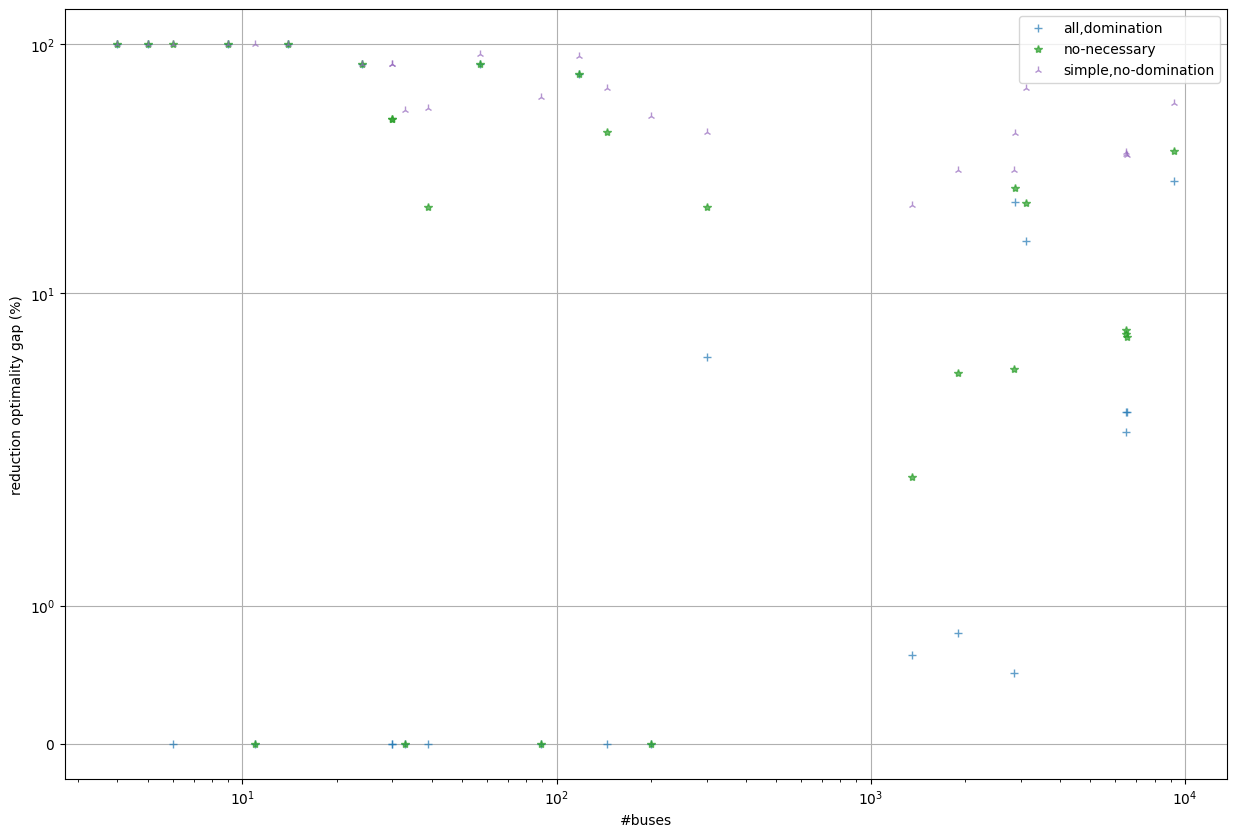

In [31]:
ax = drawPlot(x = 'n', y = 'reduction_gap', yscale='symlog', scaley=100, ignore='none domination no-domination'.split(), rename={'all': 'all,domination', 'simple': 'simple,no-domination'})
ax.legend(); ax.grid(); plt.show()

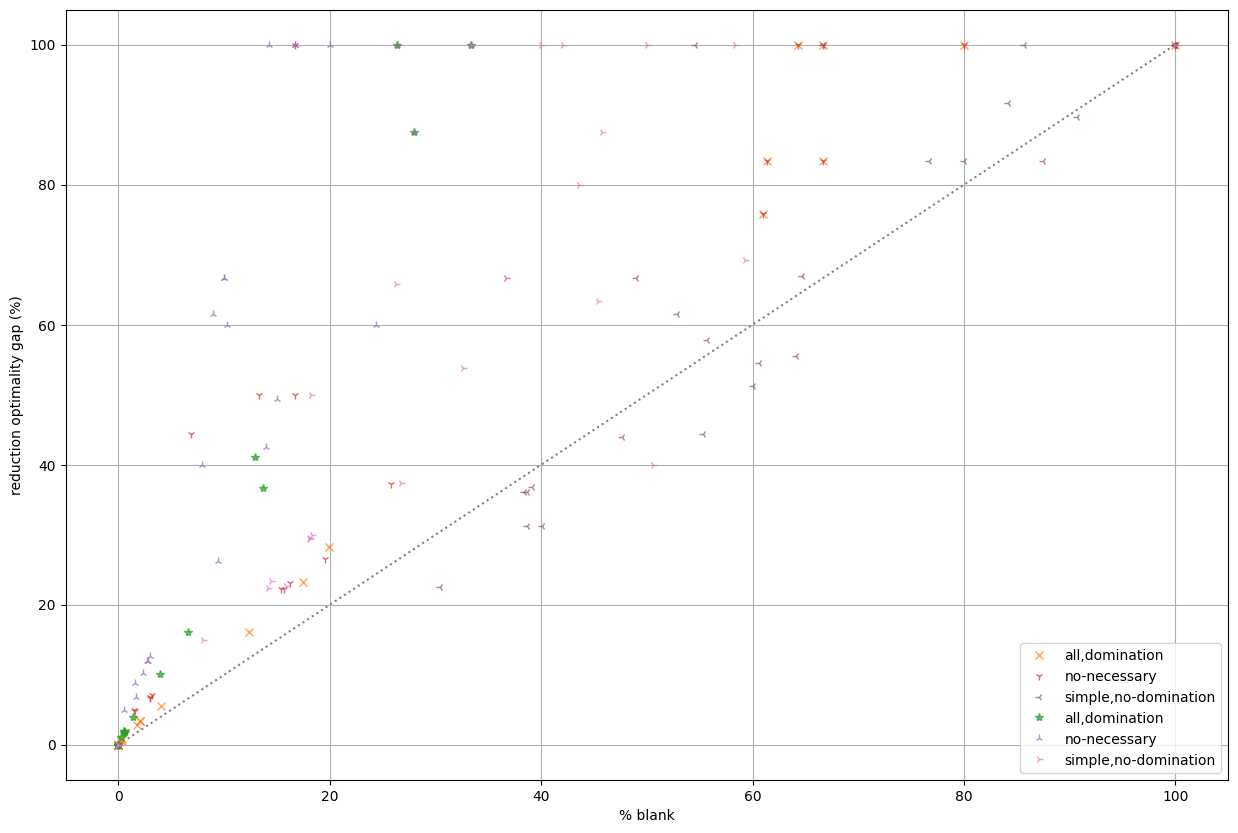

In [32]:
ax = None
ax=plt.figure(figsize=FIGSIZE).subplots(); setupAxes(ax);
ax.plot([0, 100], [0, 100], color='gray', linestyle='dotted')
ax = drawPlot(ax=ax, mode='normal',x = 'percent_blank', y = 'reduction_gap', xscale='linear', yscale='linear', scaley=100, scalex=100, ignore='none domination no-domination'.split(), rename={'all': 'all,domination', 'simple': 'simple,no-domination'})
for _ in range(5): plt.plot([],[])
ax = drawPlot(ax=ax, mode='all-zi',x = 'percent_blank', y = 'reduction_gap', xscale='linear', yscale='linear', scaley=100, scalex=100, ignore='none domination no-domination'.split(), rename={'all': 'all,domination', 'simple': 'simple,no-domination'})
ax.legend(); ax.grid();
#tikzplotlib.save('figures/blank_vs_gap.tikz.tex'); plt.show();

Another interesting relation is between the percentage of nodes left blank and the optimality gap of the reductions.
The percentage of blank vertices left is almost always higher than or at least close to the percentage of PMUs not found by the reduction rules.
The reduction rules, however, failed to identify any PMUs in some instances where they could reduce the percentage of blank vertices below 20\%.
There are many more instances where the percentage of blank vertices is much lower than the percentage of missed PMUs.
The reduction rules are thus better suited for finding inactive vertices than to find active ones.
Note, however, that a large portion of the instances is located in the lower left corner where most PMUs are found and only a small fraction of vertices remain as blank.

The correlation gets stronger when only considering larger instances.
If only instances with more han 50 nodes are included, the two have a Pearson coefficient of 0.9.
With the small instances also included, the correllation coefficient drop to 0.87.

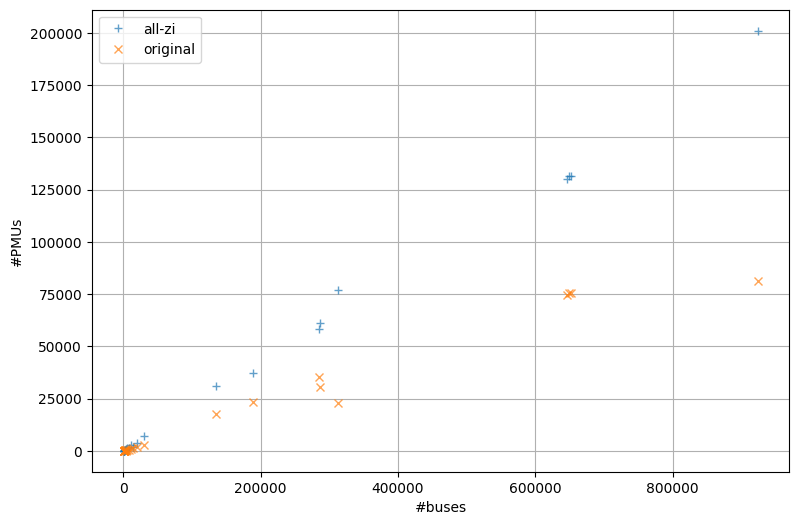

In [33]:
ax = None
ax=plt.figure(figsize=FIGSIZE*0.6).subplots(); setupAxes(ax);
#ax.plot([0, 100], [0, 100], color='gray', linestyle='dotted')
xscale, yscale = 'linear', 'linear'
ax = drawPlot(ax=ax, mode='normal',x = 'n', y = 'pmus', xscale=xscale, yscale=yscale, scaley=100, scalex=100, ignore='none domination no-domination no-necessary simple'.split(), rename={'all': 'all-zi'})
for _ in range(5): plt.plot([],[])
ax = drawPlot(ax=ax, mode='all-zi',x = 'n', y = 'pmus', xscale=xscale, yscale=yscale, scaley=100, scalex=100, ignore='none domination no-domination no-necessary simple'.split(), rename={'all': 'original'})
ax.legend(); ax.grid();
#tikzplotlib.save('figures/blank_vs_gap.tikz.tex'); plt.show();

In [34]:
x_blank = [values for mode in MODES for reduction in measurements[mode].values() for values in reduction['percent_blank']]
x_gap = [values for mode in MODES for reduction in measurements[mode].values() for values in reduction['reduction_gap']]
np.corrcoef(np.array([x_blank, x_gap]))[0, 1]

0.8728215093064242

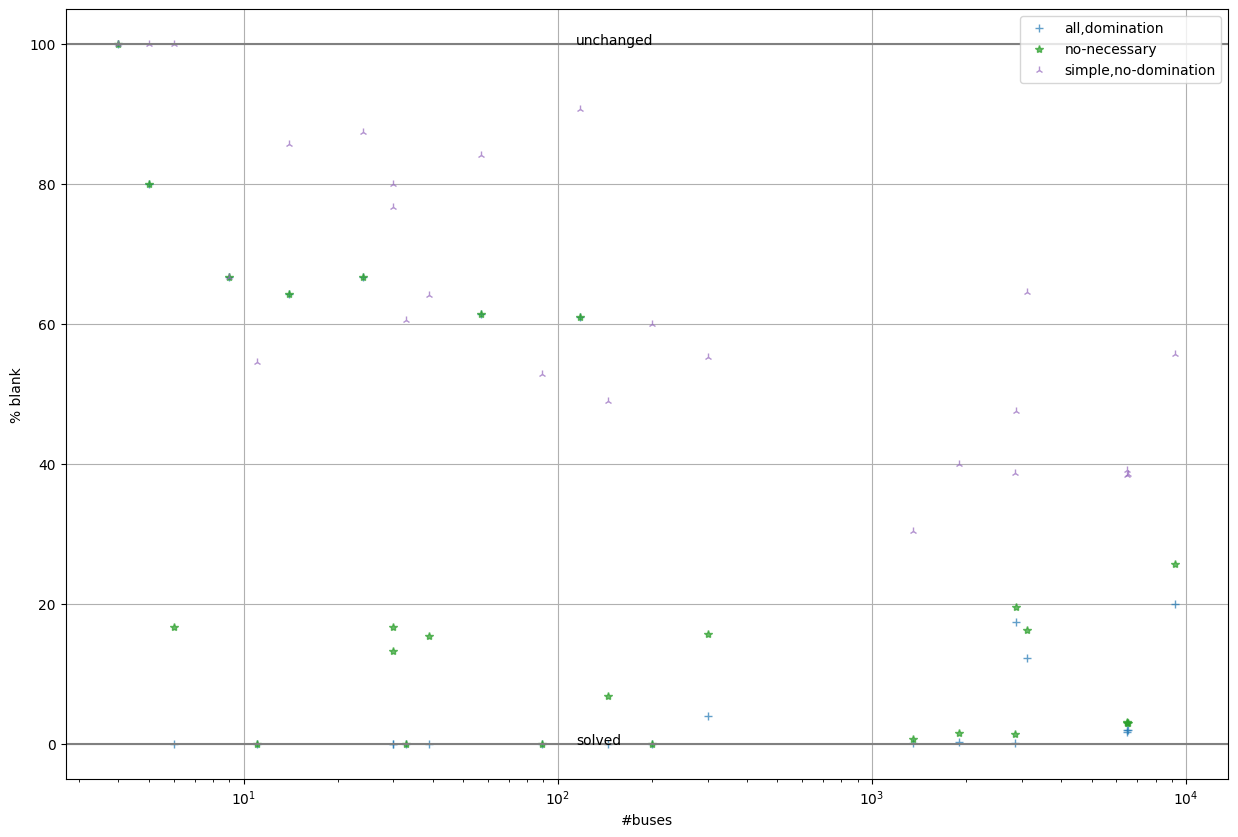

In [35]:
ax = drawPlot(x='n', y='percent_blank', yscale='linear', scaley=100, mode='normal', ignore='none domination no-domination'.split(' '), rename=dict(all='all,domination', simple='simple,no-domination'))
drawTimeouts(ax, times=[(0, 'solved'), (100, 'unchanged')])
ax.legend(); ax.grid(); #ax.set_axes_locator(mpl.ticker.SymmetricalLogLocator(subs=1))
plt.show();

While using only the “necessary” rule with the simple rules has no large effect, it can enhance the results of the domination rule (“all, domination” vs “no-necessary”).
This is because the simple rules already cover some cases of necessarily active nodes.

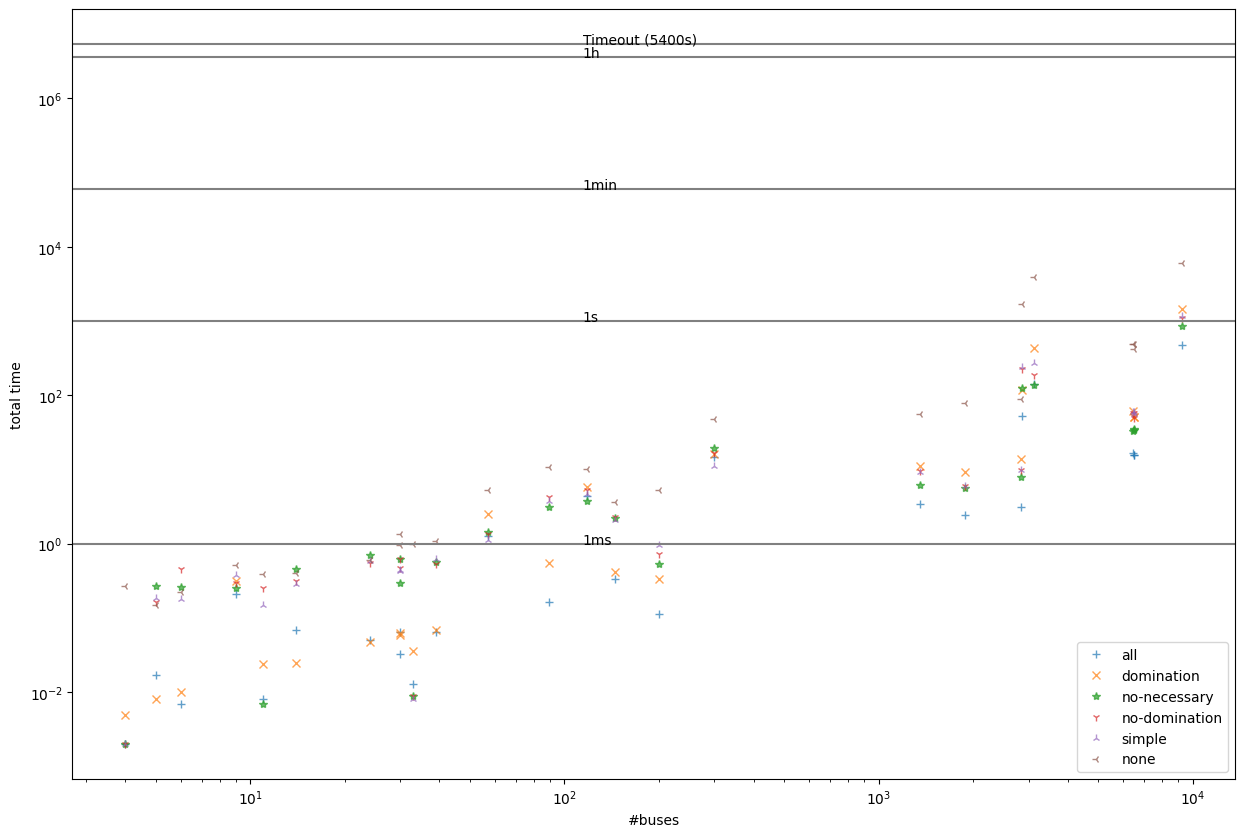

In [36]:
ax = drawPlot(x='n', y='t_total', mode='all-zi')
drawTimeouts(ax)
ax.legend()
plt.show();

When not considering all nodes zero-injection, all pandapower instances could be solved in less than one minute even without applying reduction rules.
With all reduction rules the reduction time drops by two orders of magnitude in the median instance which can also be seen in this plot.

When all nodes are zero-injection the running times are considerably higher.
In this case, one instance could not be solved before the timeout even when applying the simple reductions.
With our reduction rules applied, this instance could be solved in less than one minute.

There remain, however smoe instances which could not be solved even with our reduction rules.
Of the four US-networks, only the Texas instance could be solved when using reduction rules and not assuming only zero-injection vertices.
